### _Activity feature extractor C3D+LeedsDataset_
Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Extracting features using pretrained C3D dataset and Leeds Dataset <br>
Pretrained model couresty: https://github.com/imatge-upc/activitynet-2016-cvprw

In [1]:
import os
os.environ["KERAS_BACKEND"] = "theano"
import keras; import keras.backend
if keras.backend.backend() != 'theano':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('th')
    print("Backend ok")

Using Theano backend.


Backend ok


In [2]:
## Imports
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Sequential
import random
import numpy as np
from PIL import Image
from os import listdir
from scipy.ndimage import imread

# Custom scripts
import lscript as lsp
import modelling as md
from DataSet.DataSet import DataSet
import dataset as dset

In [3]:
time_step=40
height=112 
width=112 
channel=3
nb_class=3
imagefolderpath= ('../../../../../nobackup/leopauly/leeds_rgb/') # Folder pathe where the video sequences are stored
print(os.path.isdir(imagefolderpath))
cluster_length=16
num_clusters=2
feature_size=487

True


#### Loading Leeds Dataset

In [4]:
ds=DataSet(nb_class,time_step, height, width, channel,imagefolderpath)

Loading  ../../../../../nobackup/leopauly/leeds_rgb/push/0/0rgb.png
Loading  ../../../../../nobackup/leopauly/leeds_rgb/push/0/1rgb.png
Loading  ../../../../../nobackup/leopauly/leeds_rgb/push/0/2rgb.png
Loading  ../../../../../nobackup/leopauly/leeds_rgb/push/0/3rgb.png
Loading  ../../../../../nobackup/leopauly/leeds_rgb/push/0/4rgb.png
Loading  ../../../../../nobackup/leopauly/leeds_rgb/push/0/5rgb.png
Loading  ../../../../../nobackup/leopauly/leeds_rgb/push/0/6rgb.png
Loading  ../../../../../nobackup/leopauly/leeds_rgb/push/0/7rgb.png
Loading  ../../../../../nobackup/leopauly/leeds_rgb/push/0/8rgb.png
Loading  ../../../../../nobackup/leopauly/leeds_rgb/push/0/9rgb.png
Loading  ../../../../../nobackup/leopauly/leeds_rgb/push/0/10rgb.png
Loading  ../../../../../nobackup/leopauly/leeds_rgb/push/0/11rgb.png
Loading  ../../../../../nobackup/leopauly/leeds_rgb/push/0/12rgb.png
Loading  ../../../../../nobackup/leopauly/leeds_rgb/push/0/13rgb.png
Loading  ../../../../../nobackup/leopauly/le

#### Loading model

In [5]:
model=md.modelC3D_theano()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv1 (Convolution3D)            (None, 64, 16, 112, 1 0           convolution3d_input_1[0][0]      
____________________________________________________________________________________________________
pool1 (MaxPooling3D)             (None, 64, 16, 56, 56 0           conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution3D)            (None, 128, 16, 56, 5 0           pool1[0][0]                      
____________________________________________________________________________________________________
pool2 (MaxPooling3D)             (None, 128, 8, 28, 28 0           conv2[0][0]                      
___________________________________________________________________________________________

#### Extracting features

In [6]:
vids, labels = ds.get_batch(1)
print(vids.shape)
print(labels)

(1, 40, 112, 112, 3)
['reach']


label:0.0
Video_seq shape: (1, 40, 112, 112, 3) Label shape (1,)


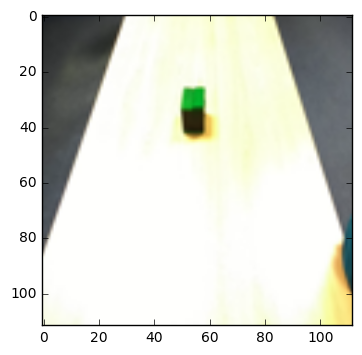

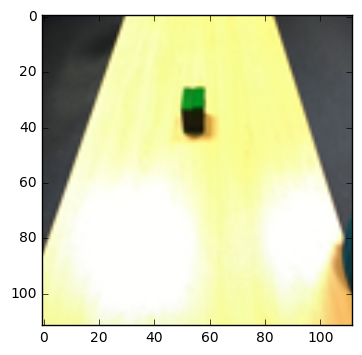

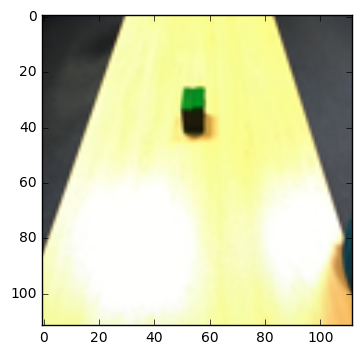

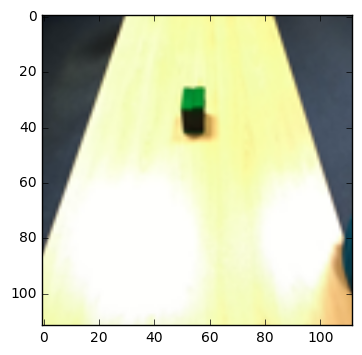

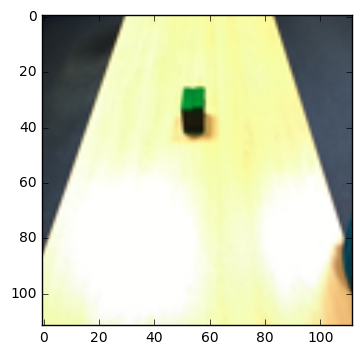

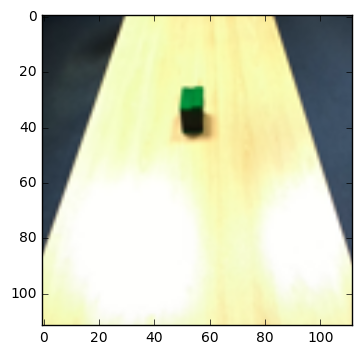

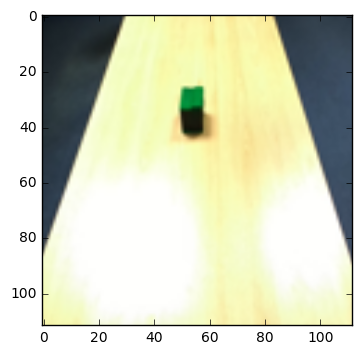

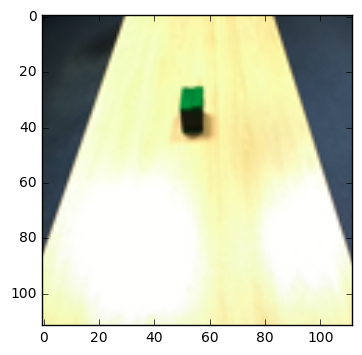

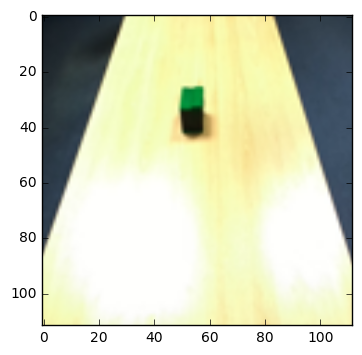

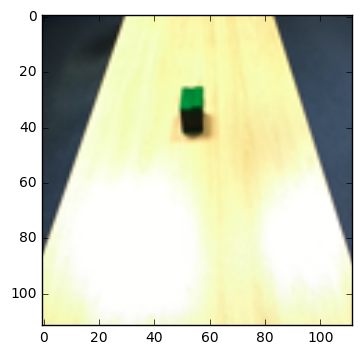

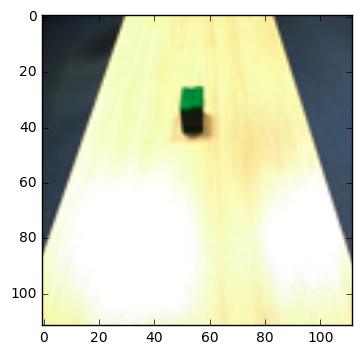

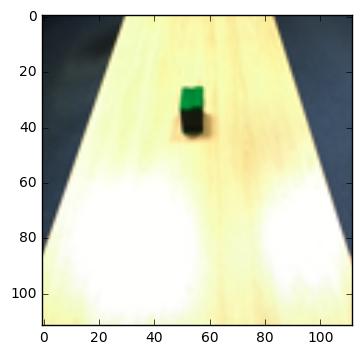

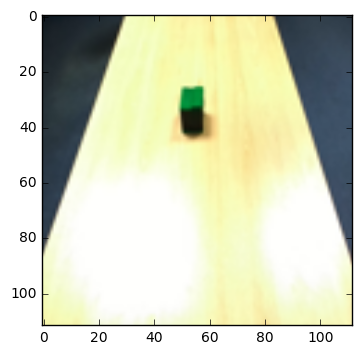

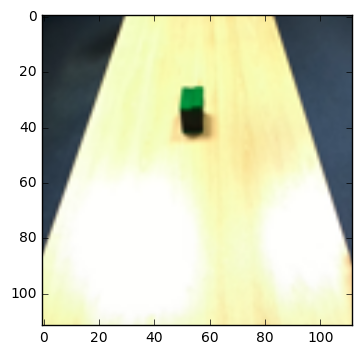

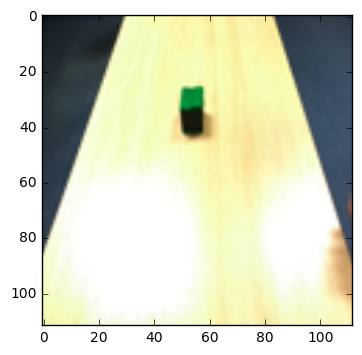

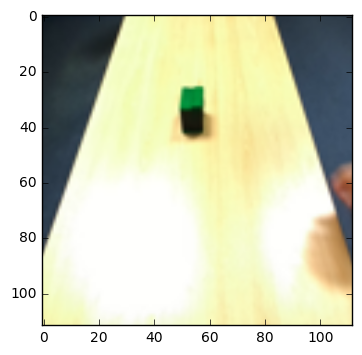

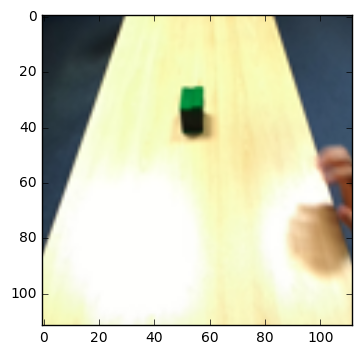

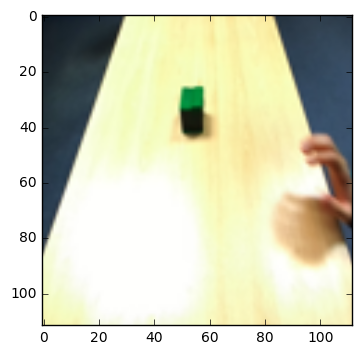

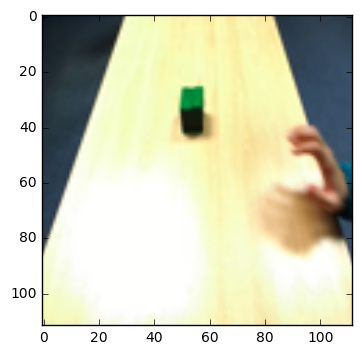

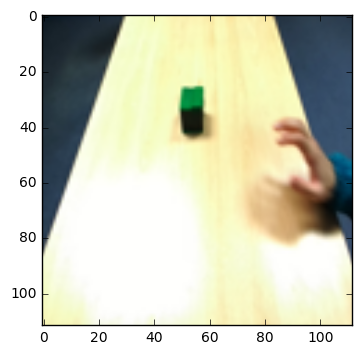

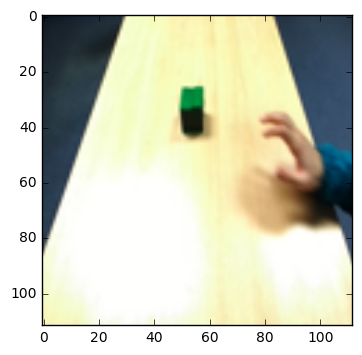

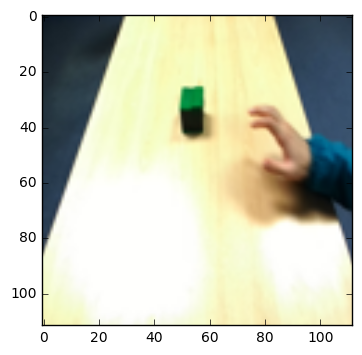

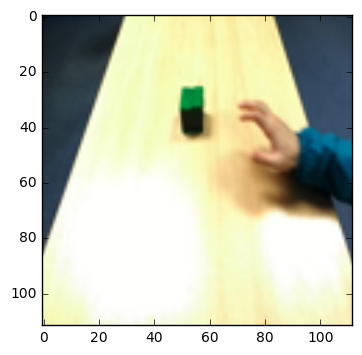

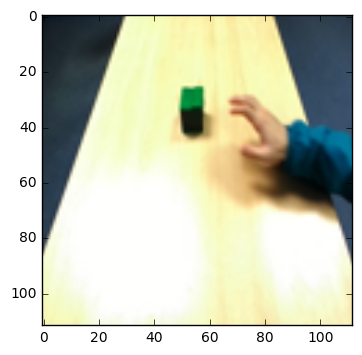

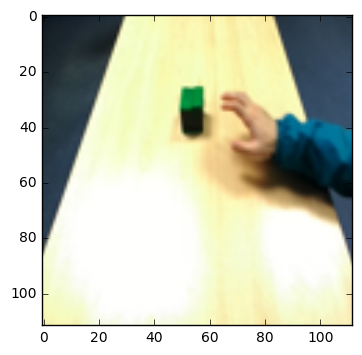

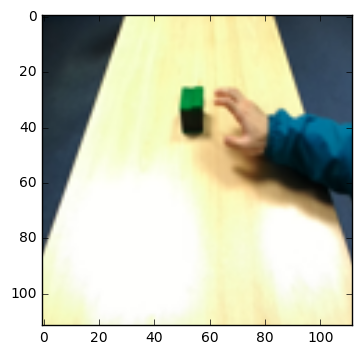

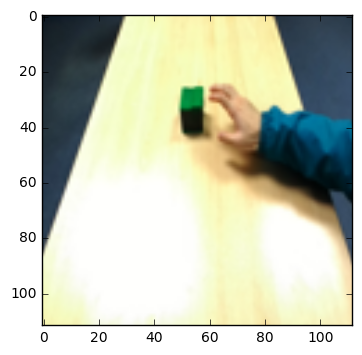

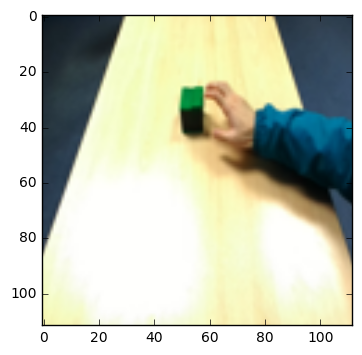

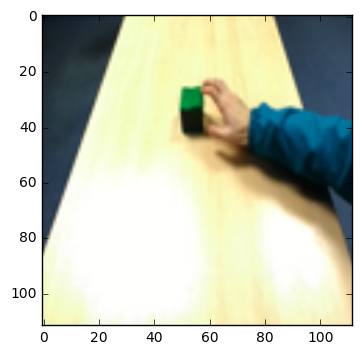

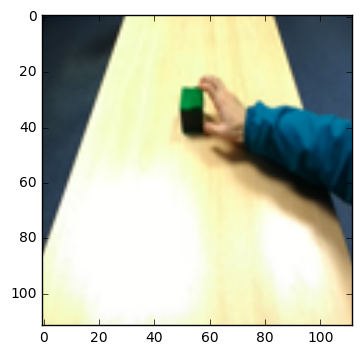

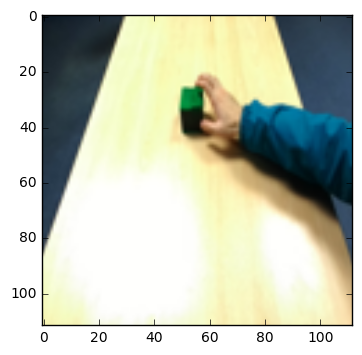

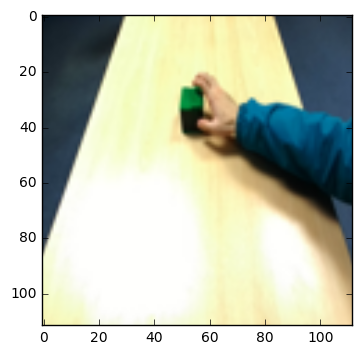

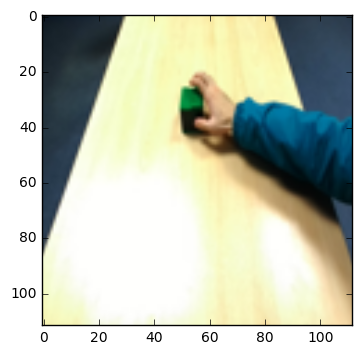

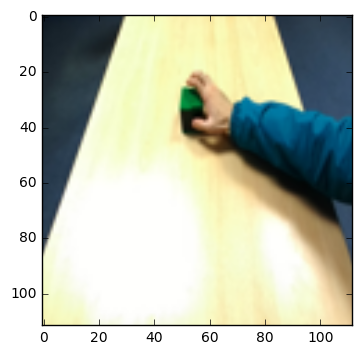

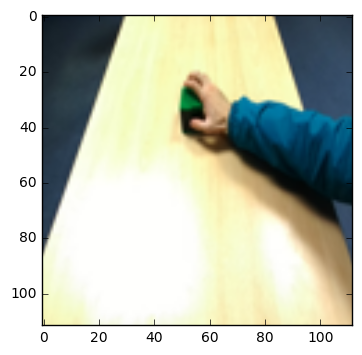

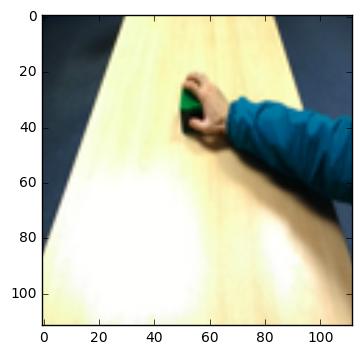

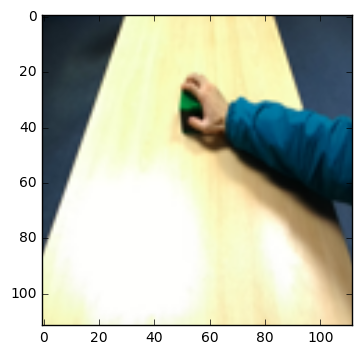

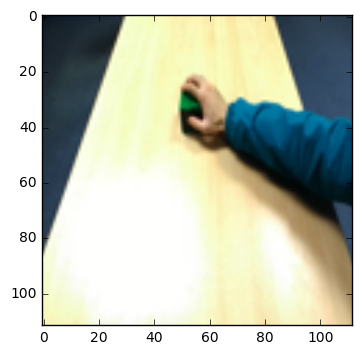

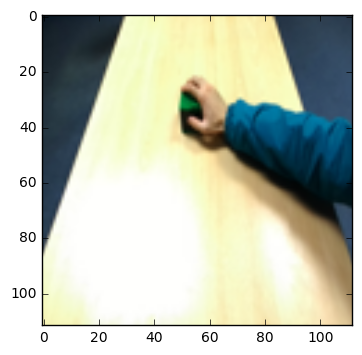

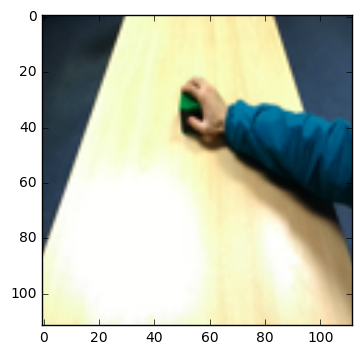

In [7]:
y_=np.zeros([1])
lsp.view_video_seq(vids,y_,40,0)

In [8]:
## Splitting into clusters the video of source demonstration
x_demo,_ =ds.get_batch(1)
x_demo_original=x_demo
x_demo =x_demo.reshape(x_demo.shape[0],x_demo.shape[1],height,width,channel)
clusters_demo=dset.cluster_generator(x_demo,num_clusters,cluster_length,height,width,channel)

## Extraction of features
print('shape of clustered demo data:',clusters_demo.shape)
features_demo=np.zeros([num_clusters,feature_size])
for i in range(num_clusters):
    t=clusters_demo[i].reshape(1,channel,cluster_length,height,width)
    features_demo[i]= model.predict(t)
    #print(features)
print('shape of features from robot actions: ',features_demo.shape)

(2, 16, 112, 112, 3)
shape of clustered demo data: (2, 16, 112, 112, 3)
shape of features from robot actions:  (2, 487)


In [9]:
## Splitting into & displaying clusters of target actions
x_robo,_=ds.get_batch(1)
x_robo_original=x_robo
x_robo =x_robo.reshape(x_robo.shape[0],x_robo.shape[1],height,width,channel)
clusters_robo=dset.cluster_generator(x_robo,num_clusters,cluster_length,height,width,channel)

## Extracting features
print('shape of clustered robot data:',clusters_robo.shape)
features_robo=np.zeros([num_clusters,feature_size])
for i in range(num_clusters):
    t=clusters_robo[i].reshape(1,channel,cluster_length,height,width)
    features_robo[i]= model.predict(t)
    #print(features)
print('shape of features from robot actions: ', features_robo.shape)

(2, 16, 112, 112, 3)
shape of clustered robot data: (2, 16, 112, 112, 3)
shape of features from robot actions:  (2, 487)


#### Extracting reward function

In [10]:
distance=np.ones([num_clusters,feature_size])
reward=np.ones([num_clusters,1])
for i in range(num_clusters):
    distance[i] = features_demo[i]-features_robo[i]
    reward[i]=-(np.linalg.norm(distance[i]))
#print(reward)
#print(dist)

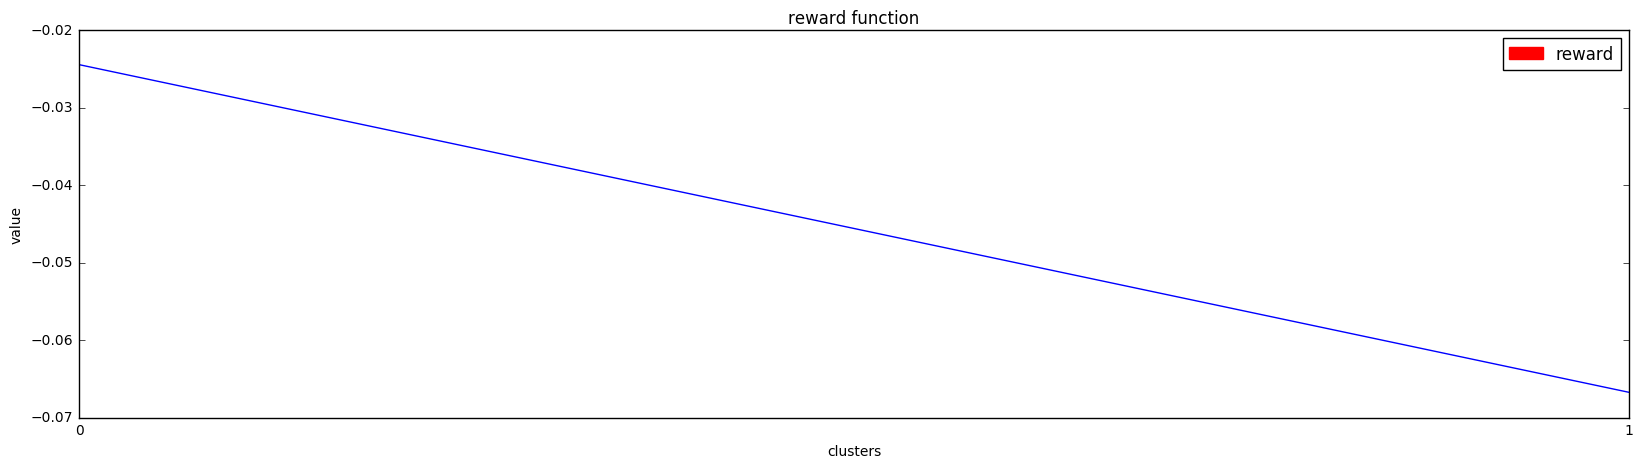

In [11]:
y_vlaues=list((range(num_clusters)))
lsp.plot_values_with_legends(y_vlaues,reward,'reward','clusters','value','reward function',color='red')

#### Displaying cluster

label:0.0
Video_seq shape: (2, 16, 112, 112, 3) Label shape (2,)


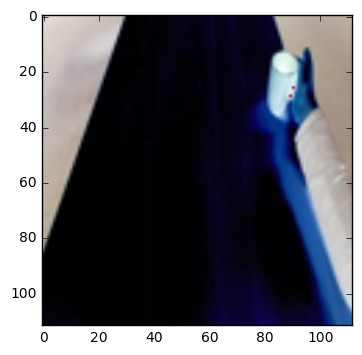

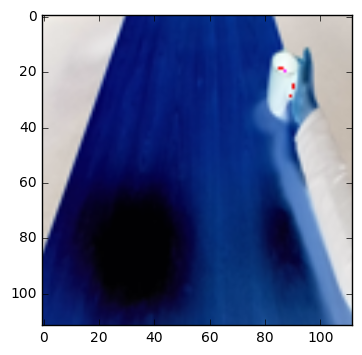

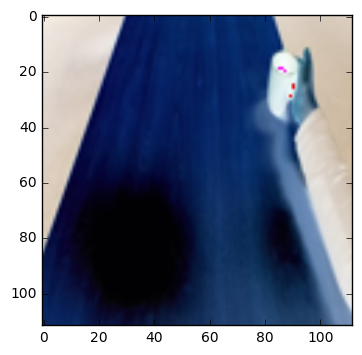

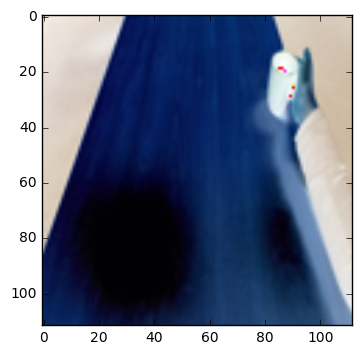

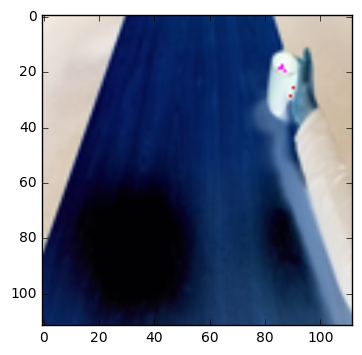

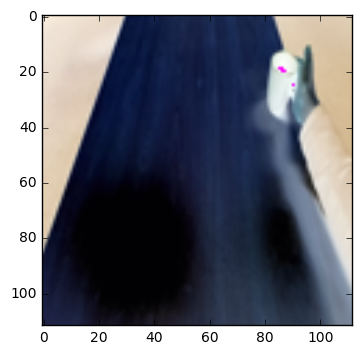

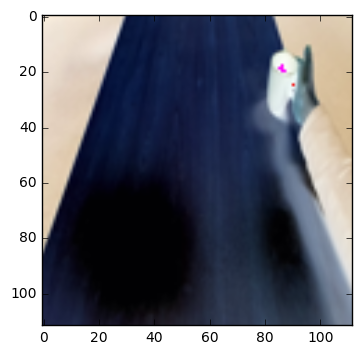

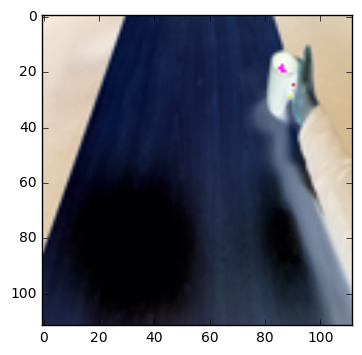

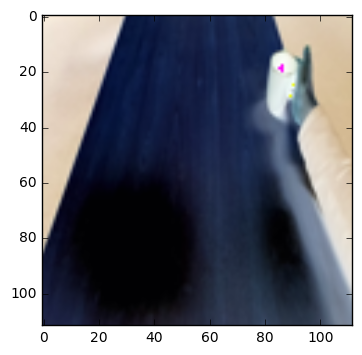

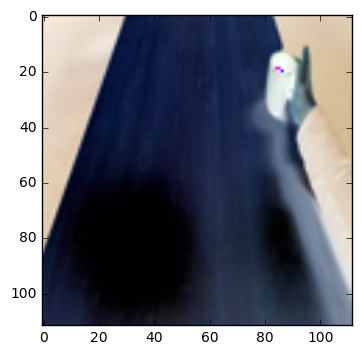

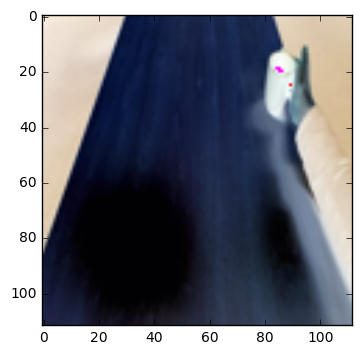

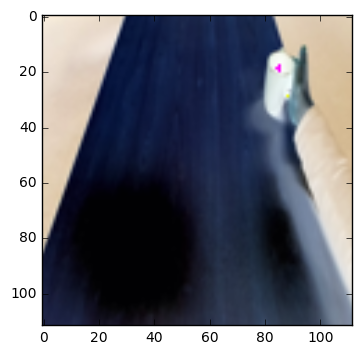

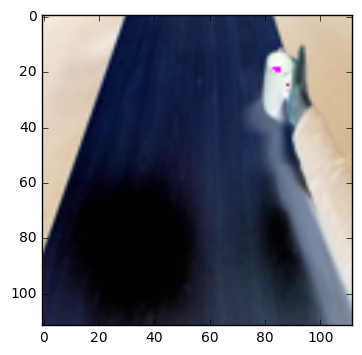

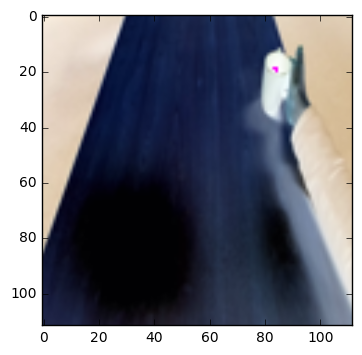

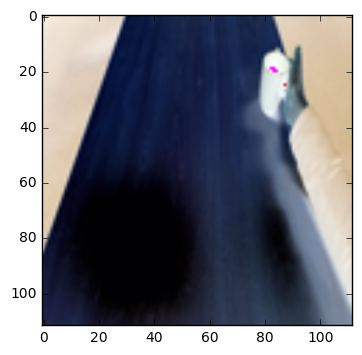

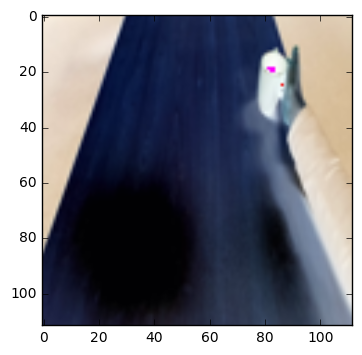

In [12]:
cluster_id=0
## Clusters from demos
y_d=np.repeat(y_,num_clusters) 
display=clusters_demo.reshape(clusters_demo.shape[0],clusters_demo.shape[1],clusters_demo.shape[2],clusters_demo.shape[3],clusters_demo.shape[4])
lsp.view_video_seq(display,y_d,cluster_length,cluster_id)

label:0.0
Video_seq shape: (2, 16, 112, 112, 3) Label shape (2,)


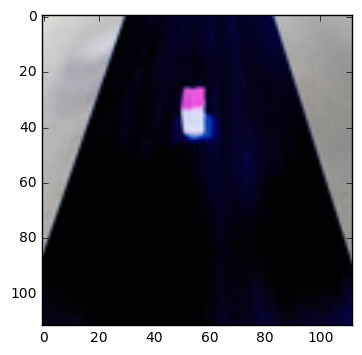

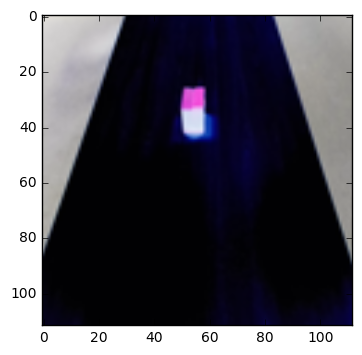

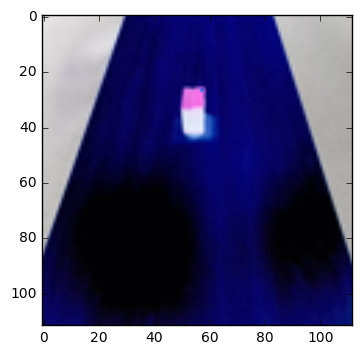

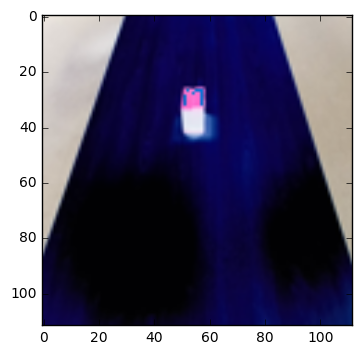

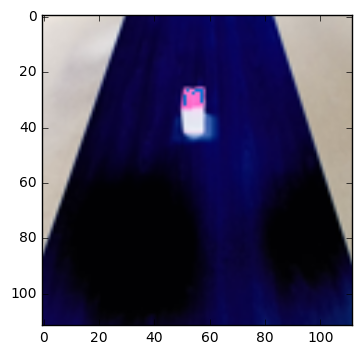

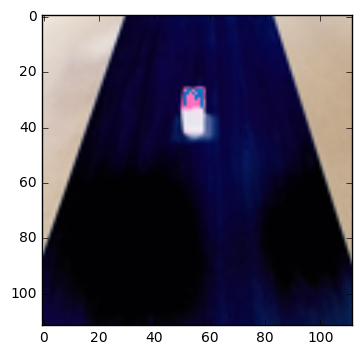

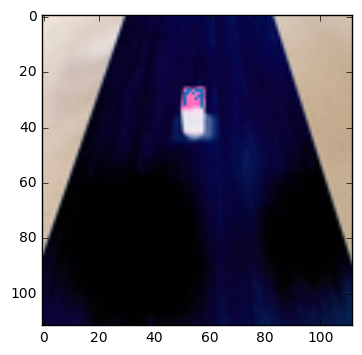

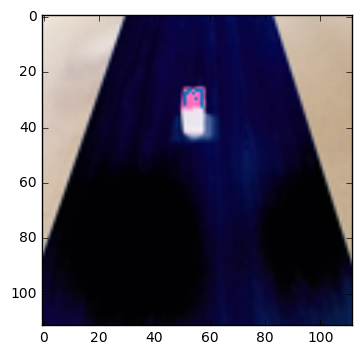

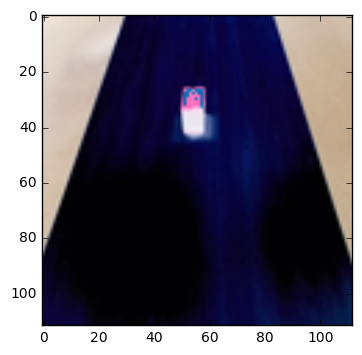

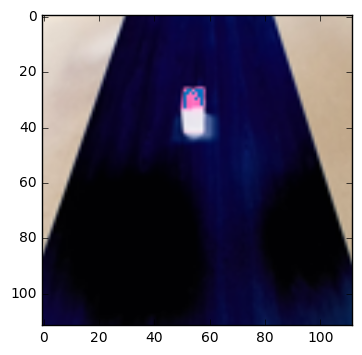

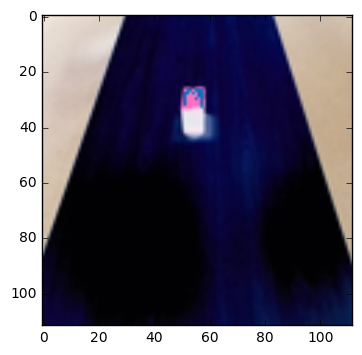

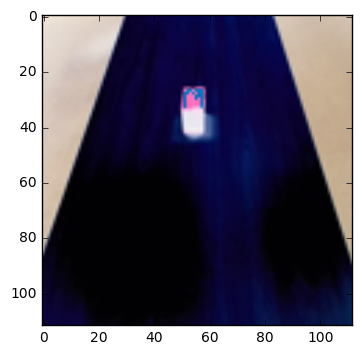

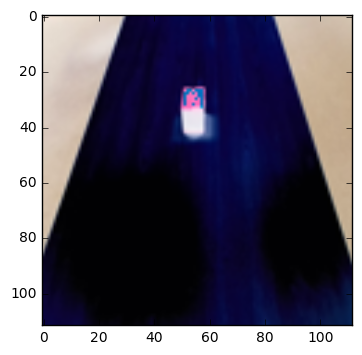

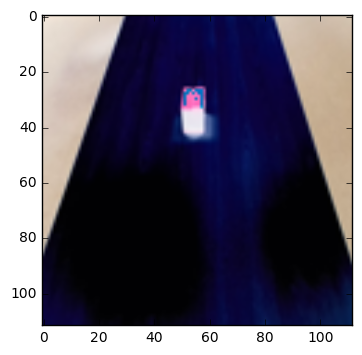

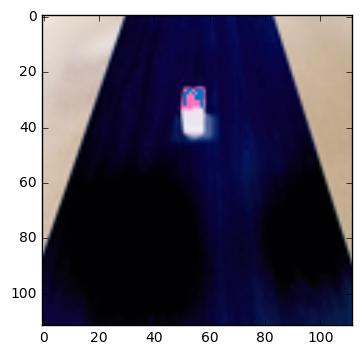

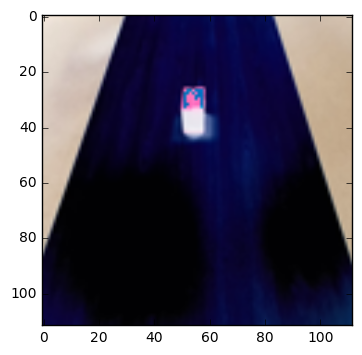

In [ ]:
# Clusters from robot action
y_r=np.repeat(y_,num_clusters) 
display=clusters_robo.reshape(clusters_robo.shape[0],clusters_robo.shape[1],clusters_robo.shape[2],clusters_robo.shape[3],clusters_robo.shape[4])
lsp.view_video_seq(display,y_r,cluster_length,cluster_id)

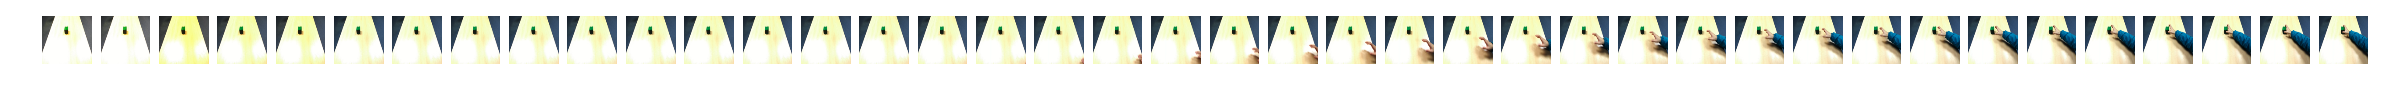

label:0.0
Video_seq shape: (1, 40, 112, 112, 3) Label shape (1,)


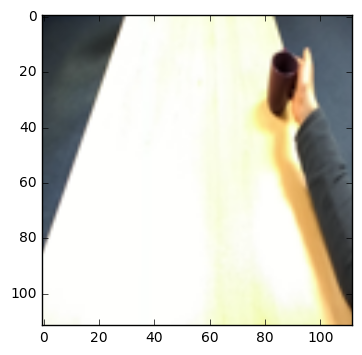

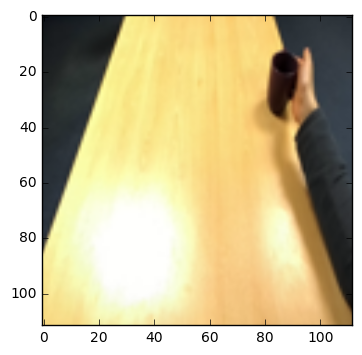

In [ ]:
y_=np.zeros([1])
lsp.view_video_inline(x_demo_original,y_,time_step,0)
lsp.view_video_seq(x_demo_original,y_,time_step,0)

In [ ]:
y_=np.zeros([1])
lsp.view_video_inline(x_robo_original,y_,time_step,0)
lsp.view_video_seq(x_robo_original,y_,time_step,0)